In [ ]:
pip install yfinance pandas numpy matplotlib scikit-learn tensorflow


In [ ]:
import yfinance as yf
import pandas as pd

# Download stock data for Apple
data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')

# Show the first few rows
data.head()

/tmp/ipython-input-12-232852236.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.288582,24.757336,23.848707,24.746228,212818400
2015-01-05,23.604332,24.137513,23.417720,24.057535,257142000
2015-01-06,23.606558,23.866483,23.244438,23.668762,263188400
2015-01-07,23.937569,24.037539,23.704302,23.815381,160423600
2015-01-08,24.857302,24.915063,24.148616,24.266361,237458000


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use only the 'Close' column
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create sequences of 60 previous days to predict the next day
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2455, 60, 1)
y shape: (2455,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Final output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 0.0277
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0019
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0016
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0015
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0013
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 0.0011
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0014
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0011
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 9.1568e-04
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0010


77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


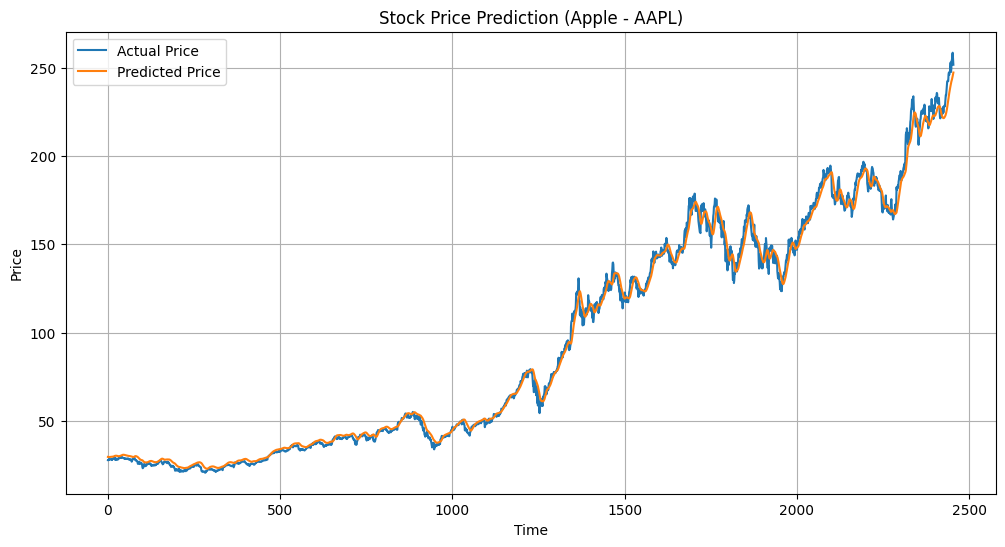

In [ ]:
# Predict on the entire dataset
predicted_prices = model.predict(X)

# Inverse transform to get actual price values (from scaled)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('Stock Price Prediction (Apple - AAPL)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Start with the last 60 entries from the original scaled data
last_60_days = scaled_data[-60:].reshape(1, 60, 1)
future_predictions = []

for _ in range(7):  # Predict next 7 days
    prediction = model.predict(last_60_days)[0][0]
    future_predictions.append(prediction)

    # Update input with new prediction
    new_input = np.append(last_60_days[0][1:], [[prediction]], axis=0)
    last_60_days = new_input.reshape(1, 60, 1)

# Inverse scale to get actual price values
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Print predicted values
for i, price in enumerate(future_predictions_actual, 1):
    print(f"Day {i}: ${price[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Day 1: $247.74
Day 2: $247.83
Day 3: $247.60
Day 4: $247.15
Day 5: $246.56
Day 6: $245.88
Day 7: $245.14


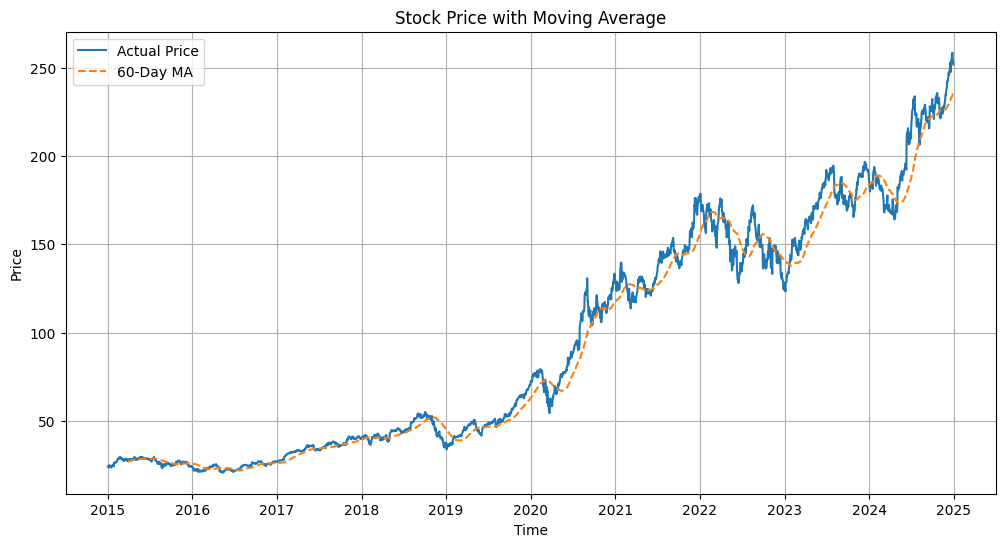

In [ ]:
# Calculate 60-day moving average
data['MA60'] = data['Close'].rolling(window=60).mean()

# Plot with moving average
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Actual Price')
plt.plot(data['MA60'], label='60-Day MA', linestyle='--')
plt.title('Stock Price with Moving Average')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


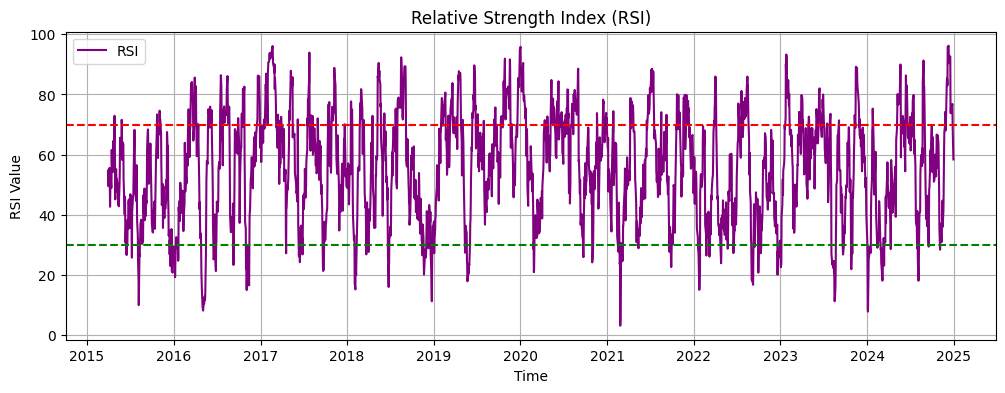

In [ ]:
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Add RSI to your dataframe
data['RSI'] = compute_rsi(data)

# Drop initial NaN values caused by rolling window
data.dropna(inplace=True)

# Plot RSI
plt.figure(figsize=(12,4))
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Time')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()
